In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from sklearn import preprocessing

from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding, GRU
from keras.layers import Convolution1D, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.layers.normalization import BatchNormalization


from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

from multiprocessing import Pool

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('ggplot')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [3]:
#spacy.util.set_data_path('/home/data/spacy/en-1.1.0')
#spacy.util.set_data_path('/home/data/spacy/en_glove_cc_300_1m_vectors-1.0.0')
nlp = spacy.load('en')

# Загрузка данных

In [4]:
train_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/train.data', index_col=0)
test_set = pd.read_table('/home/data/shad-yelp-sentiment-analysis/test.data', index_col=0)

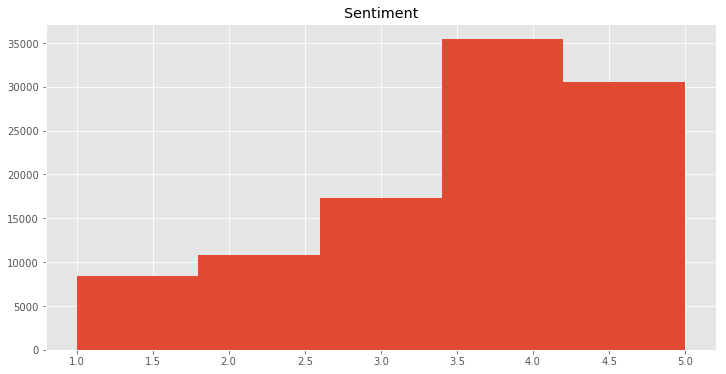

In [5]:
train_set.hist(column='Sentiment', bins=5, figsize=(12, 6))
plt.show()

In [6]:
Y_train = train_set['Sentiment']
Y_train_categorical = np_utils.to_categorical(Y_train)[:, 1:]

In [7]:
Y_train_counts = train_set['Sentiment'].value_counts()[[1, 2, 3, 4, 5]]
Y_train_counts

1     8457
2    10798
3    17340
4    35432
5    30517
Name: Sentiment, dtype: int64

In [8]:
Y_train_percents = Y_train_counts/Y_train.size
Y_train_percents = Y_train_percents.values
Y_train_percents

array([ 0.08247191,  0.10530114,  0.16909814,  0.34552972,  0.29759908])

# Data Preparation

## Tokenization

### Spacy.io

In [9]:
def remove_character_from_string(s, old_characters_list=['\n', '\t'], new_characters_list=None):
    if not new_characters_list:
        new_characters_list = [' ']*len(old_characters_list)
        
    for old_c, new_c in zip(old_characters_list, new_characters_list):
        s = s.replace(old_c, new_c)
        
    return s

def remove_extra_spaces(s):
    return ' '.join( s.split() )

In [12]:
money_regex = r'\$[0-9.,]+'

def money_regex_replace(s):
    return re.sub(money_regex, ' money ', s)

In [13]:
dots_regex = r'\.[.]+'

def dots_replace(s):
    return re.sub(dots_regex, ' ... ', s)

In [14]:
def clear_string(s, to_lower=True):
    s = remove_character_from_string(s, 
                                     ['\\n', '\\"', '-', '"', "\\", ')', '(', '/'], 
                                     [' ', ' ', ' - ', ' ', '', ' ) ', ' ( ', ' / '])
    s = money_regex_replace(s)
    s = dots_replace(s)
    s = remove_extra_spaces(s)
    s = s.lower() if to_lower else s
    return s

In [15]:
def tokenize_string_spacy(s):
    s = clear_string(s)
    text = [token.text for token in nlp(s)]
    return ' '.join(x for x in text)

def tokenize_string_spacy_objects(s):
    s = clear_string(s, to_lower=False)
    return nlp(s)

# Features

In [16]:
train_tokenized_objects = train_set['Text'].apply(tokenize_string_spacy_objects)
test_tokenized_objects = test_set['Text'].apply(tokenize_string_spacy_objects)

### word2vec, text, lower

In [18]:
def text_from_tokens_spacy(tokens):
    tokens = [token.text for token in tokens]
    return ' '.join(tokens)

train_features = train_tokenized_objects.apply(text_from_tokens_spacy)
test_features = test_tokenized_objects.apply(text_from_tokens_spacy)

In [19]:
w2v_parh = os.path.join(os.sep, os.path.abspath('/home/data/word2vec/english/GoogleNews-vectors-negative300.bin'))
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_parh, binary=True)
w2v.init_sims(replace=True)

In [20]:
def tokens_sequence_embedding(words):
    sequence = [w2v.syn0norm[w2v.vocab[word].index] 
                if word in w2v.vocab else np.zeros(300) 
                for word in words.split(' ')]

    if not sequence:
        return np.zeros(300)

    return np.concatenate(sequence)

#### Множества(train, test, validation)

In [46]:
x_train, x_validation, y_train, y_validation = train_test_split(train_features.values, Y_train_categorical,
                                                                test_size=0.1, random_state=42)

# Models

### Convolutional Sentiment NN without Embending layer

### batch_generator

In [47]:
batch_size, timesteps, data_dim = 64, 1000, 300

def pad_or_truncate(a, n):
    if len(a)<n:
        a = np.lib.pad(a, (n-len(a), 0), mode='constant', constant_values=0)
    if len(a)>n:
        a = a[:n]
    return a.reshape((timesteps, data_dim))

def batch_to_sequence(texts):
    result = [tokens_sequence_embedding(text) for text in texts]
    result = np.array([pad_or_truncate(l, data_dim*timesteps) for l in result])
    return result

In [48]:
def batch_generator(X, Y, batch_size, shuffle=False):
    number_of_batches, counter, shuffle_index = X.shape[0]//batch_size, 0, np.arange(Y.shape[0])
    
    if shuffle:
        np.random.shuffle(shuffle_index)
    
    X, Y =  X[shuffle_index], Y[shuffle_index]
    
    while True:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch, Y_batch = X[index_batch], Y[index_batch]
        counter += 1
        yield batch_to_sequence(X_batch), Y_batch
        
        if counter == number_of_batches:
            if shuffle:
                np.random.shuffle(shuffle_index)
            counter=0

### model

In [ ]:
histories = []

def get_nn_model(*, path_to_hdf5=False, input_dim=None):
    input_dim = x_train.shape[1] if not input_dim else input_dim
    
    # Create model
    model = Sequential()
    model.add(GRU(128, recurrent_dropout=0.2, dropout=0.2, batch_input_shape=(batch_size, timesteps, data_dim)))
    model.add(Dense(5, kernel_initializer='he_normal', activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="weights_{epoch:02d}_{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [55]:
histories = []

def get_nn_model(*, path_to_hdf5=False, input_dim=None):
    input_dim = x_train.shape[1] if not input_dim else input_dim
    
    # Create model
    model = Sequential()
    model.add(Convolution1D(64, 3, activation='relu', batch_input_shape=(batch_size, timesteps, data_dim)))
    model.add(Convolution1D(64, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(Convolution1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='he_normal', activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    print(model.summary())
    return model

filepath="weights_{epoch:02d}_{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

### training

In [ ]:
steps_per_epoch = batch_size*(x_train.shape[0]//batch_size)

model = get_nn_model(input_dim=(batch_size, data_dim, timesteps))
history = model.fit_generator(generator=batch_generator(x_train, y_train, batch_size, shuffle=True),
                              steps_per_epoch=steps_per_epoch,
                              validation_data=batch_generator(x_validation, y_validation, batch_size, shuffle=False),
                              validation_steps=x_validation.shape[0],
                              epochs=5, verbose=0, callbacks=[TQDMNotebookCallback(), checkpoint])

histories.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (64, 998, 64)             57664     
_________________________________________________________________
conv1d_14 (Conv1D)           (64, 996, 64)             12352     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (64, 332, 64)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (64, 330, 128)            24704     
_________________________________________________________________
conv1d_16 (Conv1D)           (64, 328, 128)            49280     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (64, 109, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (64, 13952)               0         
__________

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 00000: val_acc improved from -inf to 0.37500, saving model to weights_00_0.375.hdf5


The installed widget Javascript is the wrong version.


Epoch 00001: val_acc improved from 0.37500 to 0.42188, saving model to weights_01_0.422.hdf5


The installed widget Javascript is the wrong version.


Epoch 00002: val_acc did not improve


The installed widget Javascript is the wrong version.


KeyboardInterrupt: 

# Ответ

In [111]:
test_set['Sentiment'] = [np.argmax(a)+1 for a in model.predict(test_features_counts_array)]
test_set[['Sentiment']].to_csv('ans.csv')